# MaxCut, Random Graphs and Unit Disc Embedding

The purpose of this notebook was to explore a few questions I thought of after looking at some of Pasqal's research papers and the tutorials/examples in Pulser.  

Because of [previous work I did with QAOA-MaxCut](https://iopscience.iop.org/article/10.1088/2058-9565/ac6973/meta) I wanted to understand: 

* How MaxCut can be implemented on Chadoq2
* How random graphs (e.g. k-regular, Erdős-Rényi, random weighted) could be embedded using the Pasqal Register for either MIS or MaxCut.  
* How to translate QAOA circuits/schedules to Pasqal pulses.  

I only got a chance to work through some of the first 2 bullets and would appreciate any feedback! In the notebook I ask several questions where relevant. 

[Pasqal's reference on combinatorial optimization](https://arxiv.org/abs/2207.13030) notebook [QAOA and QAA to solve a MIS problem](https://github.com/pasqal-io/Pulser/blob/develop/tutorials/applications/QAOA%20and%20QAA%20to%20solve%20a%20MIS%20problem.ipynb) were very helpful and I use content from them below.

## MIS and MaxCut Cost Functions

The cost function for MIS is:

$$
C(z_1,\dots,z_N) = -\sum_{i=1}^N z_i + U \sum_{\langle i,j \rangle}z_i z_j
$$

where $U \gg 1$  and $\langle i,j \rangle$ represents adjacent nodes (i.e. there is a link between node $i$ and $j$).

The cost function for MaxCut (in the un-weighted case) is:

$$
C(z_1,\dots,z_N) = -\sum_{i=1}^N N(i) z_i + U \sum_{\langle i,j \rangle}z_i z_j
$$

where $N(i)$ is the number of neighbors of vertex $i$. 

## Pasqal Analog Hamiltonian

From [QAOA and QAA to solve a MIS problem](https://github.com/pasqal-io/Pulser/blob/develop/tutorials/applications/QAOA%20and%20QAA%20to%20solve%20a%20MIS%20problem.ipynb):

"Interestingly, the operator $\hat{C}$ associated with the cost function of the previous equation(s) can be natively realized on a neutral atom platform with some constraints on the graph edges. We map a  ground state and a Rydberg state of each atom to a two-level system, where $|1 \rangle = |r \rangle$ is a Rydberg state and $|0 \rangle = |g \rangle$ is a ground state. An atom in a Rydberg state has an excited electron with a very high principal quantum number and therefore exhibits a huge electric dipole moment. As such, when two atoms are excited to Rydberg states, they exhibit a strong van der Waals interaction. Placing $N$ atoms at positions $\textbf{r}_j$ in a 2D plane, and coupling the ground state $|0\rangle$ to the Rydberg state $|1\rangle$ with a laser system enables the realization of the Hamiltonian :"

$$
H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2}  \sigma_i^z+\sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j.
$$

"Here, $\Omega$ and $\delta$ are respectively the Rabi frequency and detuning of the laser system and $\hbar$ is the reduced Planck constant. The first two terms of the equation govern the transition between states $|0\rangle$ and $|1 \rangle$ induced by the laser, while the third term represents the repulsive Van der Waals interaction between atoms in the $|0\rangle$ state. More precisely, $n_i = \frac 12 (\sigma_i
^z + 1)$ counts the number of Rydberg excitations at position $i$. The interaction strength between two atoms decays as $|\textbf{r}_i-\textbf{r}_j|^{-6}$."

One can use the change of variables to $ n_i $ to get a form like Eq. (10) of [Pasqal's Combinatorial Ref](https://arxiv.org/pdf/2207.13030.pdf).

## Graph to Register

After specifying the Hamiltonian, the next step is to embed the graph instance into a Pasqal  Register. 

From [Pasqal's Combinatorial Ref](https://arxiv.org/pdf/2207.13030.pdf):

"One of the features of neutral atom devices
that makes it interesting for combinatorial graph
problems is that the ground state of the Hamiltonian can encode exactly the solution to MIS on unit disk (UD) graphs. Given a graph, if
an embedding in two dimensions can be found
such that two nodes are connected if and only
if their Euclidean distance is less than a certain
threshold, then the graph is said to be a unit
disk graph."

So the task of embedding is to find a Unit Disc graph representation of the particular graph instance you want to solve. [This notebook has a description of the procedure:](https://github.com/pasqal-io/Pulser/blob/develop/tutorials/applications/QAOA%20and%20QAA%20to%20solve%20a%20MIS%20problem.ipynb):

"A link in the graph corresponds to two atoms that are within the Rydberg Blockade Radius (RBR) of each other. The radius of RBR is directly linked to the Rabi frequency  and is obtained using Chadoq2.rydberg_blockade_radius(). In this notebook,  is initially fixed to a frequency of 1 rad/µs."

More details about the embedding from [Pasqal's Combinatorial Ref](https://arxiv.org/pdf/2207.13030.pdf):

"When a UD embedding of a graph is replicated
on a neutral atom device, the two-body interaction term in (10) forbids the simultaneous excitation of two atoms that are closer than a certain
distance, a phenomenon known as the Rydberg
blockade [5]. This ensures that the evolution of
the quantum system is restricted to a subspace of
the complete Hilbert space where the excitations
correspond to independent sets of the graph. For
positive detunings, moreover, excitations are energetically favored, leading to the ground state of
the system to be a maximum independent set of
the graph."

"Furthermore, solving the
MaxCut problem might potentially imply selecting two or more connected nodes, hence violating the blockade radius-based constraint. For instance, any cutting set of maximum size on complete graphs whose order is greater than three
will have at least one pair of connected nodes. To
overcome the aforementioned issues, other embedding strategies should be considered."


Question: I would like to understand this more, are there reccomended references? I am looking at Section 3.1 from [Pasqal's Combinatorial Ref](https://arxiv.org/pdf/2207.13030.pdf) concerning embedding strategies. Overall I would like to know how to implement MaxCut on whatever graphs possible (including random). 

### Graph embedding

Given the aspect of the Hamiltonian mentioned in the previous section, I continued on with the task of embedding but without a specific Hamiltonian in mind.  I wanted to get a sense for the following from [Pasqal's Combinatorial Ref](https://arxiv.org/pdf/2207.13030.pdf):

"However, finding a unit-disk realization for a
given graph is proven to be NP-hard [51] and,
as the reader may anticipate, not all graphs have
such an embedding"

I did some experiments described below.

In [1]:
import numpy as np
import igraph as ig
from itertools import combinations
import matplotlib.pyplot as plt

I took the suggested algorithm Fruchterman Reingold from [Pasqal's Combinatorial Ref](https://arxiv.org/pdf/2207.13030.pdf) to produce a UD layout and compute all "weights" ($|\textbf{r}_i-\textbf{r}_j|$) between nodes (atoms):

In [15]:
def get_layout_weights(G,layout_type='fr'):
    
    if layout_type=='fr':
        layout = G.layout_fruchterman_reingold()
    elif layout_type=='frw1':        
        layout = G.layout_fruchterman_reingold(weights=[1]*len(G.get_edgelist()))
    else:
        layout = G.layout_fruchterman_reingold()
        
    weights = []
    for pair in G.get_edgelist():
        c0 = layout.coords[pair[0]]
        c1 = layout.coords[pair[1]]
        weights.append( np.sqrt( (c0[0] - c1[0])**2 + (c0[1] - c1[1])**2)) #abs(rij)
        
    return layout,weights

The layout_fruchterman_reingold method has options, like the intial layout, weights for the edges, and others which deserve more attention with experiments (see discussion at end). 

For a 4-2 random regular graph a layout can be found which has equal weights ($|\textbf{r}_i-\textbf{r}_j|$):

1.144859664189262
7.007092818840969e-12


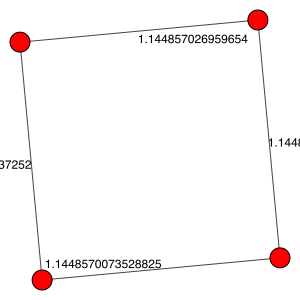

In [16]:
nnodes = 4 
k = 2
G = ig.Graph.K_Regular(nnodes,k)
layout,weights = get_layout_weights(G)
mean = sum(weights)/len(weights) 
var = sum([((x-mean)**2) for x in weights]) / len(weights)
print(mean)
print(var)
ig.plot(G, layout=layout,edge_label=weights,bbox=(0, 0, 300, 300))

The output FR layout is taken and a scale factor is chosen so that radii with edges overlap with each other below:

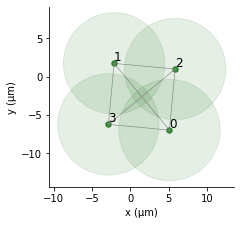

7


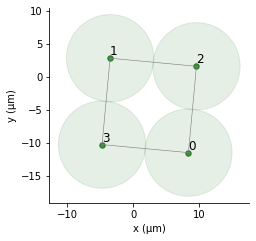

11.5


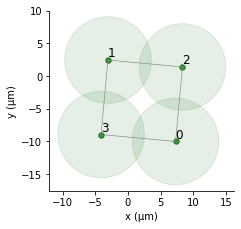

10.0


In [17]:
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2

Chadoq2.rydberg_blockade_radius(1.0)

#scale coords to adjust the Van der Waals interaction
def scale_coords(layout,scale=10):
    scaled_coords = []      
    for elem in layout.coords:
        x = elem[0]
        y = elem[1]
        scaled_coords.append([scale*x,scale*y])
    return scaled_coords

scales=[7,11.5,10.0]
for scale in scales:
    scaled_coords = scale_coords(layout,scale)
    qubits = dict(enumerate(scaled_coords))
    reg = Register(qubits)
    reg.draw(
        blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
        draw_graph=True,
        draw_half_radius=True,
    )
    print(scale)

A scale of 10 seems to create a reasonable layout $ r_j $ with overlaps.  

From the discussion in the Hamiltonian section, the interaction term:


$$
\sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j.
$$

For the current graph instance and $ i = 0 $ has 2 potential interactions with $ i = 1,3 $ but the Rydberg blockade will restrict to just one.  

Which one will be selected? I'd like to understand more about this feature.  Perhaps there is a sequence of embeddings with blockade restrictions that could account for the degree of interactions?

As we increase nnodes,k we can produce graphs for which the FR algorithm does not produce equal weights for:

1.1376737199484666
0.05558421213050667


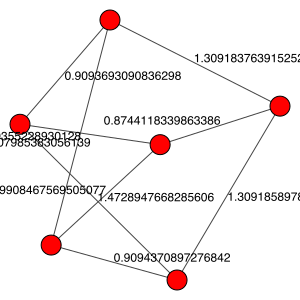

In [18]:
nnodes = 6
k = 3
G = ig.Graph.K_Regular(nnodes,k)
layout,weights = get_layout_weights(G)
mean = sum(weights)/len(weights) 
var = sum([((x-mean)**2) for x in weights]) / len(weights)
print(mean)
print(var)
ig.plot(G, layout=layout,edge_label=weights,bbox=(0, 0, 300, 300))

The following tests examine the weights for random k regular graphs for non-trivial sizes (nnodes).  I wanted to get a sense for how the FR layout algorithm behaves asymptotically for these graphs:

In [12]:
def kreg_weights(nnodes,k):
    G = ig.Graph.K_Regular(nnodes,k)
    layout,weights = get_layout_weights(G)
    mean = sum(weights)/len(weights) 
    var = sum([((x-mean)**2) for x in weights]) / len(weights)
    return mean,var,weights

For $k=2$ and nnodes>4 the variance/mean of the weights increases with nnodes:

In [13]:
k=2
for nnodes in [4,8,16,128,1024,4096]:
    mean,var,weights = kreg_weights(nnodes,k)
    print(nnodes,'\t',mean,'\t',var,'\t',var/mean)

4 	 1.144745156605653 	 1.0869875591551389e-09 	 9.495454537481736e-10
8 	 1.0295887213836756 	 0.02714295864073358 	 0.0263629137314712
16 	 1.0831497256332012 	 0.013784235470288096 	 0.012726066529934202
128 	 3.214687300696171 	 0.3428006445438141 	 0.10663576655483019
1024 	 0.6796977633125321 	 0.06536059540300654 	 0.09616126303619019
4096 	 0.7456841563374775 	 0.10152809765348877 	 0.13615429105019064


This is not the case for $k>2$, and the asymptotic behavior is interesting:

In [14]:
k=3
for nnodes in [4,8,16,128,1024,4096]:
    mean,var,weights = kreg_weights(nnodes,k)
    print(nnodes,'\t',mean,'\t',var,'\t',var/mean)

4 	 0.9715285507367093 	 0.0277848716274729 	 0.028599130315216836
8 	 1.2477851070801935 	 0.10703451621419259 	 0.08577960708687447
16 	 1.6274188190906058 	 0.13444334796005133 	 0.08261140057061504
128 	 3.2391909193104103 	 0.8691489006174398 	 0.26832283810009955
1024 	 1.0592766711984745 	 0.15266527052708292 	 0.1441221870338711
4096 	 1.1038071744496778 	 0.1571816348075258 	 0.14239954083093492


I interpret these results as an inability for $k \ge 2$ graphs to admit a UD layout which results in equal weights ($|\textbf{r}_i-\textbf{r}_j|$), although for $k=3$ it seems asymptotically that the weights have a lower overall variance/mean, and may be trending towards an approximate equal-weight UD embedding. Perhaps one can use these embeddings for large graphs in an approximate way. The constraint of "equal weights" helps me to understand how weighted problems might be handled, or how they could be used to fix the equal-weight UD embedding for random graphs!

There are other interesting parameters to consider with regard to the FR algorithm such as:

* initial layout
* weights
* iterations

as well as other algorithms, some of these are discussed [Pasqal's Combinatorial Ref](https://arxiv.org/pdf/2207.13030.pdf). 

Overall this is a very interesting platform!  Looking forward to learning more about it.